In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [23]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()
# index = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})
# index

In [24]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [47]:
rolling_window = 10
market.connect()
prices = []
skips = 1
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            dividends = market.query("dividends",{"ticker":ticker})
            if dividends.index.size > 0:
                dividends = p.utc_date(dividends)
                price = price.merge(dividends,on=["date","ticker"])
                price["dividend"] = price["rate"].ffill().fillna(0)
            else:
                price["dividend"] = 0
            price = Metric.DISTANCE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Indicator.EMACorr.calculate(price,timeframe=rolling_window)
            price = RiskType.COEFFICIENT_OF_VARIATION.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 19%|███████████████████████████████████▊                                                                                                                                                      | 2167/11261 [00:49<03:15, 46.63it/s]

index 0 is out of bounds for axis 0 with size 0


 30%|████████████████████████████████████████████████████████                                                                                                                                  | 3394/11261 [01:20<03:36, 36.36it/s]

index 0 is out of bounds for axis 0 with size 0


 45%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 5039/11261 [01:58<02:09, 47.95it/s]

index 0 is out of bounds for axis 0 with size 0


 46%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 5212/11261 [02:02<02:08, 47.15it/s]

index 0 is out of bounds for axis 0 with size 0


 48%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 5419/11261 [02:06<02:03, 47.12it/s]

index 0 is out of bounds for axis 0 with size 0


 48%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 5439/11261 [02:07<02:18, 41.97it/s]

index 0 is out of bounds for axis 0 with size 0


 51%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 5723/11261 [02:14<02:10, 42.45it/s]

index 0 is out of bounds for axis 0 with size 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 8782/11261 [03:24<00:54, 45.43it/s]

index 0 is out of bounds for axis 0 with size 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 9808/11261 [03:48<00:29, 49.65it/s]

index 0 is out of bounds for axis 0 with size 0


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 10225/11261 [03:57<00:17, 58.05it/s]

index 0 is out of bounds for axis 0 with size 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [04:20<00:00, 43.18it/s]


In [48]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [123]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "ema_corr"
                                                            ]
                                                            ,num_of_groups=[3]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[3]
                                                            ,min_prices=[1]
                                                            ,stoplosses=[0.05]
                                                            ,rolling_windows=[rolling_window]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "day"  and "top_blacklist" in portfolio.selection_type.label  and portfolio.allocation_type.label == "risk" \
            and portfolio.position_type.label == "long" and portfolio.grouping_type.value ==  "distance" and portfolio.max_price > portfolio.min_price:
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

1

In [124]:
analysises = []
portfolio_value = 10
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.34s/it]


In [125]:
a = pd.DataFrame(analysises)

In [126]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","timeframe","selection_percentage","stoploss","position_type","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,grouping_type,selection_type,allocation_type,num_of_groups,max_price,min_price,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
0,ema_corr,DISTANCE,top_blacklist,risk,3,3,1,117319.363001,3.686494e+06,0.95,5.102594,22992.100884,5.102499,22991.763381,5.102574


In [127]:
# orivault.cloud_connect()
# orivault.drop("results")
# orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
# orivault.disconnect()

In [108]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

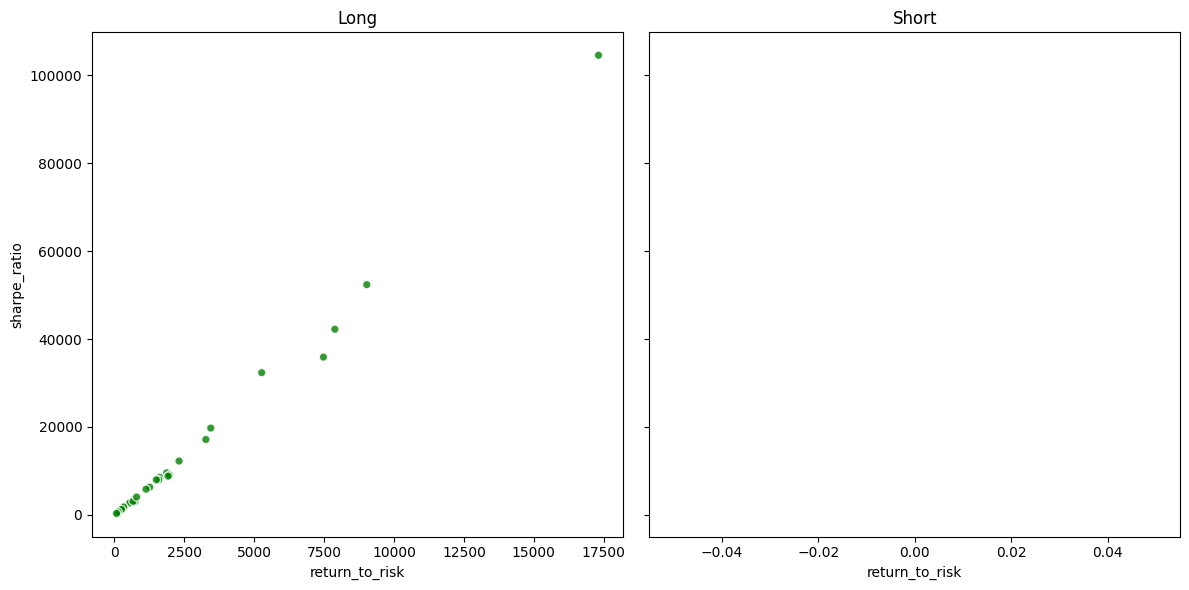

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [110]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

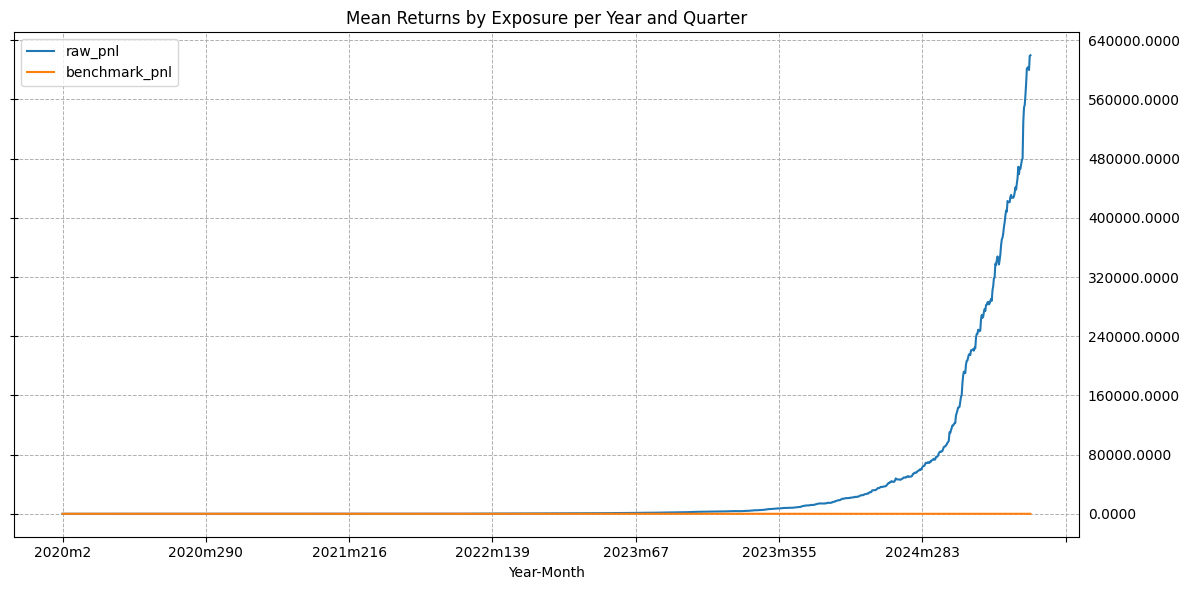

In [111]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [112]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
FATBP,0.022540
TSLT,0.020887
DAVE,0.013117
EVO,0.010531
CDIO,0.010170
...,...
AGD,-0.005613
CNCK,-0.005635
SIM,-0.005788


In [113]:
portfolio.sort_values("date")

,index,year,day,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,quarter,week,Year-Month
0,0,2020,2,2020-01-02 00:00:00+00:00,1.005597,1.004475,1.004475,1.005597,120.64,1.000000,1,1,1,2020m2
1,1,2020,3,2020-01-03 00:00:00+00:00,1.015303,1.015303,1.019846,1.020986,119.06,0.986903,1,1,1,2020m3
2,2,2020,6,2020-01-06 00:00:00+00:00,1.011003,1.011003,1.031067,1.032220,118.97,0.986157,1,1,2,2020m6
3,3,2020,7,2020-01-07 00:00:00+00:00,0.998980,0.998980,1.030015,1.031167,116.94,0.969330,1,1,2,2020m7
4,4,2020,8,2020-01-08 00:00:00+00:00,1.009309,1.009309,1.039604,1.040766,117.86,0.976956,1,1,2,2020m8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,1347,2025,133,2025-05-13 00:00:00+00:00,1.000945,1.000945,101946.401706,602577.114030,263.01,2.180123,5,2,20,2025m133
1348,1348,2025,134,2025-05-14 00:00:00+00:00,1.002418,1.002418,102192.921606,604034.225288,265.64,2.201923,5,2,20,2025m134
1349,1349,2025,135,2025-05-15 00:00:00+00:00,0.993031,0.993031,101480.738137,599824.704869,267.49,2.217258,5,2,20,2025m135
1350,1350,2025,136,2025-05-16 00:00:00+00:00,1.031739,1.028560,104379.040033,618862.752874,267.56,2.217838,5,2,20,2025m136


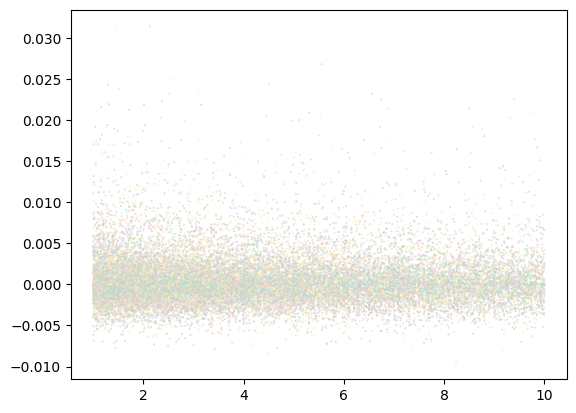

In [114]:
plt.scatter(trades["adjclose"],trades["return"],s=0.1,c=trades["group_percentile"].astype(int)*10,cmap="Pastel2")
plt.show()

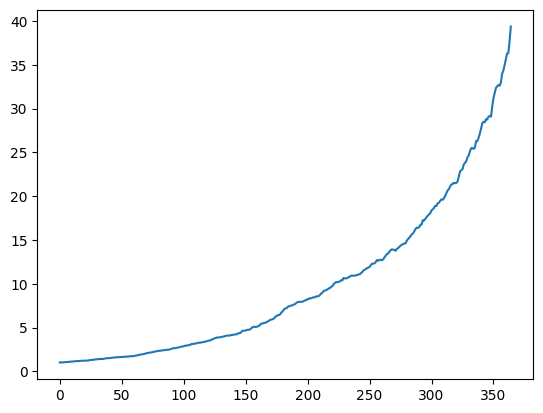

In [115]:
averaged_portfolio = portfolio.groupby("day").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["weighted_return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()

In [116]:
trades.tail(20)

,major_key,year,day,ticker,date,adjclose,sell_price,distance,ema_corr,risk,...,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter,week
13500,2025_98_1,2025,98,YHC,2025-04-08 00:00:00+00:00,5.705,5.8420,1.779864,-2.158825,1.079484,...,-1.0,0.011074,0.975986,0.975986,0.975986,-0.000266,-0.000266,4,2,15
13501,2025_98_10,2025,98,RDW,2025-04-08 00:00:00+00:00,7.710,9.9700,1.315758,-0.212392,0.146151,...,-1.0,0.081797,0.706874,0.950000,0.950000,-0.004090,-0.004090,4,2,15
13502,2025_98_2,2025,98,STSS,2025-04-08 00:00:00+00:00,5.070,4.2000,1.765185,-2.882167,0.795578,...,-1.0,0.015026,1.171598,1.171598,1.171598,0.002578,0.002578,4,2,15
13503,2025_98_3,2025,98,ACRV,2025-04-08 00:00:00+00:00,1.360,1.6100,1.709357,-0.643405,0.503682,...,-1.0,0.023735,0.816176,0.950000,0.950000,-0.001187,-0.001187,4,2,15
13504,2025_98_4,2025,98,SRFM,2025-04-08 00:00:00+00:00,2.090,2.4800,1.662294,-0.264278,0.211119,...,-1.0,0.056625,0.813397,0.950000,0.950000,-0.002831,-0.002831,4,2,15
13505,2025_98_5,2025,98,WNW,2025-04-08 00:00:00+00:00,1.540,1.6488,1.598399,-0.363363,0.266390,...,-1.0,0.044877,0.929351,0.950000,0.950000,-0.002244,-0.002244,4,2,15
13506,2025_98_6,2025,98,SAIH,2025-04-08 00:00:00+00:00,3.550,4.4300,1.577983,-0.303813,0.290501,...,-1.0,0.041152,0.752113,0.950000,0.950000,-0.002058,-0.002058,4,2,15
13507,2025_98_7,2025,98,ALVOW,2025-04-08 00:00:00+00:00,1.070,1.5100,1.521258,-0.281292,0.287897,...,-1.0,0.041524,0.588785,0.950000,0.950000,-0.002076,-0.002076,4,2,15
13508,2025_98_8,2025,98,CRMD,2025-04-08 00:00:00+00:00,6.790,7.0000,1.453256,-0.293513,0.260792,...,-1.0,0.045840,0.969072,0.969072,0.969072,-0.001418,-0.001418,4,2,15
13509,2025_98_9,2025,98,CAPR,2025-04-08 00:00:00+00:00,8.700,9.4000,1.390504,-0.245149,0.159900,...,-1.0,0.074763,0.919540,0.950000,0.950000,-0.003738,-0.003738,4,2,15
